## seqFISH Processing Example

In [1]:
import os
from copy import deepcopy
from itertools import product

import numpy as np
import pandas as pd
import skimage.filters
import skimage.morphology
from skimage.transform import SimilarityTransform, warp
from tqdm import tqdm

import starfish
import starfish.data
from starfish.types import Axes, Levels, TraceBuildingStrategies

import matplotlib.pyplot as plt


### Load Image

In [2]:
exp = starfish.data.SeqFISH(use_test_data=True)
img = exp['fov_000'].get_image('primary')

### Processing

In [3]:
# Remove cellular autofluorescence w/ gaussian high-pass filter
ghp = starfish.image.Filter.GaussianHighPass(sigma=3)
ghp.run(img, verbose=False, in_place=True)

# Increase resolution by deconvolving w/ point spread function
dpsf = starfish.image.Filter.DeconvolvePSF(num_iter=15, sigma=3)
dpsf.run(img, verbose=False, in_place=True)

# Scale intensities in each volume and clip all but high intensity pixels
clip = starfish.image.Filter.Clip(p_min=90, p_max=99.9, is_volume=True, level_method=Levels.SCALE_BY_CHUNK)
scaled = clip.run(img, in_place=False)


100%|█████████████████████████████████████████████████████████████████████████████████████| 1740/1740 [00:02<00:00, 606.93it/s]


### Spot Finding

In [4]:
threshold = 0.1

bd = starfish.spots.FindSpots.BlobDetector(
    min_sigma=(1, 1, 1),
    max_sigma=(5, 5, 5),
    num_sigma=10,
    threshold=threshold)

spots = bd.run(scaled)


### Decoding

Comparison between using PerRoundMaxChannel w/ NEAREST_NEIGHBOR TraceBuildingStrategies and the three different accuracy modes of the CheckAll decoder.

Runs each decoder for three different search radii parameters (1, 2, and 3) and creates a bar plot showing the total number of decoded mRNA targets found by each method. For the CheckAll decoder columns, the number of non-error corrected barcodes is denoted by a black line in the bar while the full height of the bar shows the combined number of error-corrected and non-error-corrected barcodes. 



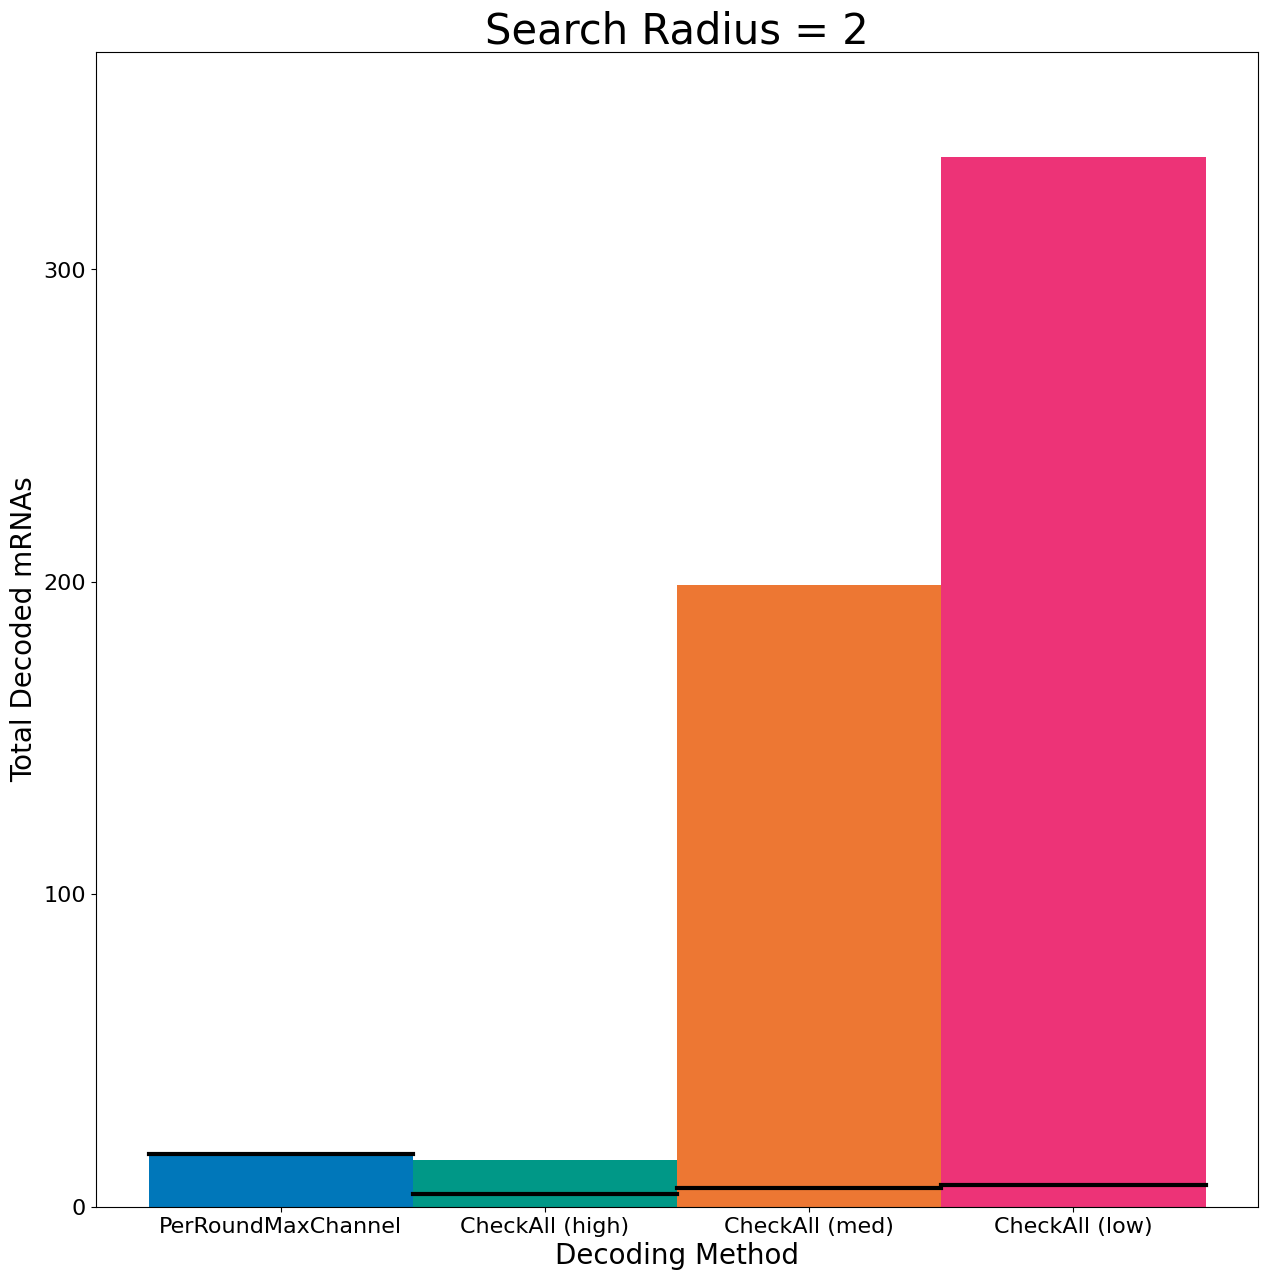

In [5]:
# Set the number of cpu cores to use in parallel for the CheckAll decoder. This significantly cuts down on run time.
n_cpus = 4

# Run each decoder for different search radius values
#for radius in [2, 3, 4]:
for radius in [2]:
    
    # Decode using PerRoundMaxChannel NEAREST_NEIGHBOR method
    decoder = starfish.spots.DecodeSpots.PerRoundMaxChannel(
        codebook=exp.codebook,
        search_radius=radius,
        trace_building_strategy=TraceBuildingStrategies.NEAREST_NEIGHBOR)

    decoded_prmc = decoder.run(spots=spots)
    decoded_prmc = decoded_prmc[decoded_prmc['passes_thresholds']]

    # Decode using high accuracy CheckAll method
    decoder = starfish.spots.DecodeSpots.CheckAll(codebook=exp.codebook,
                                                  search_radius=radius,
                                                  error_rounds=1,
                                                  mode='high')

    checkall_high = decoder.run(spots=spots, n_processes=n_cpus)

    # Decode using medium accuracy CheckAll method
    decoder = starfish.spots.DecodeSpots.CheckAll(codebook=exp.codebook,
                                                  search_radius=radius,
                                                  error_rounds=1,
                                                  mode='med')

    checkall_med = decoder.run(spots=spots, n_processes=n_cpus)

    # Decode using low accuracy CheckAll method
    decoder = starfish.spots.DecodeSpots.CheckAll(codebook=exp.codebook,
                                                  search_radius=radius,
                                                  error_rounds=1,
                                                  mode='low')

    checkall_low = decoder.run(spots=spots, n_processes=n_cpus)

    # Plot total number of barcodes from each method (black line shows number of full barcodes while bar height is
    # the combined number of both error-corrected and non-error-corrected)
    fig, axes = plt.subplots(1, 1, figsize=(15,15))

    labels = ['PerRoundMaxChannel', 'CheckAll (high)', 'CheckAll (med)', 'CheckAll (low)']
    axes.bar([1], len(decoded_prmc), color=(0/256, 119/256, 187/256), width=1, label='PerRoundMaxChannel')
    axes.plot([0.5, 1.5], [len(decoded_prmc), len(decoded_prmc)], color='black', linewidth=3)
    axes.bar([2], len(checkall_high), color=(0/256, 153/256, 136/256), width=1, label='CheckAll (high)')
    axes.plot([1.5, 2.5],
              [len(checkall_high[checkall_high['rounds_used'] == 5]), len(checkall_high[checkall_high['rounds_used'] == 5])],
              color='black', linewidth=3)
    axes.bar([3], len(checkall_med), color=(238/256, 119/256, 51/256), width=1, label='CheckAll (med)')
    axes.plot([2.5, 3.5],
              [len(checkall_med[checkall_med['rounds_used'] == 5]), len(checkall_med[checkall_med['rounds_used'] == 5])],
              color='black', linewidth=3)
    axes.bar([4], len(checkall_low), color=(238/256, 51/256, 119/256), width=1, label='CheckAll (low)')
    axes.plot([3.5, 4.5],
              [len(checkall_low[checkall_low['rounds_used'] == 5]), len(checkall_low[checkall_low['rounds_used'] == 5])],
              color='black', linewidth=3)

    axes.set_xticks(range(1,5))
    axes.set_xticklabels(labels, size=16)
    axes.set_yticks(range(0, int(len(checkall_low)+len(checkall_low)/10+1), 100))
    axes.set_yticklabels(range(0, int(len(checkall_low)+len(checkall_low)/10+1), 100), size=16)
    axes.set_ylim(0, len(checkall_low)+len(checkall_low)/10)
    axes.set_xlabel('Decoding Method', size=20)
    axes.set_ylabel('Total Decoded mRNAs', size=20)
    axes.set_title(f'Search Radius = {radius}', size=30)